In [1]:
import math as mth
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from plotly import graph_objects as go
from scipy import stats as st
from statsmodels.stats.multitest import multipletests

# Исследование воронки продаж

## Содержание: <a name='mark_'></a> 

### [Описание проекта](#mark0)  
### [Загрузка данных](#mark1)
### [Предобработка данных](#mark2)
### [Анализ данных](#mark3)
### [Изучение воронки событий](#mark4) 
### [Изучение результатов эксперимента](#mark5)


# Описание проекта <a name='mark0'></a>  
Небходимо проанализирововать поведение пользователей мобильного приложения интернет-магазина.  
Изучим воронку продаж и узнаем, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?  

Дизайнеры захотели поменять шрифты приложения, а менеджеры предупредили, что пользователям может быть непривычно. Перед внедрение новых шрифтов необходимо провести A/A/B-тест. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

# Загрузка данных<a name='mark1'></a>

In [2]:
# путь к документу
path = 'E:\\Python\\datasets\\'

In [3]:
logs = pd.read_csv(path + 'logs_exp.csv', sep='\t')

In [4]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Описание данных

Таблица **logs**:
- **EventName** — название события;
- **DeviceIDHash** — уникальный идентификатор пользователя;
- **EventTimestamp** — время события;
- **ExpId** — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Данные загружены и готовы к дальнейшей работе

[Обратно к содержанию](#mark_)

# Предобработка данных<a name='mark2'></a>

Изменим названия столбцов:

In [5]:
logs.set_axis(['event', 'user_id', 'event_time', 'group'], axis = 'columns', inplace = True)

Проверим пропуски и типы данных:

In [6]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event         244126 non-null object
user_id       244126 non-null int64
event_time    244126 non-null int64
group         244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В нашем датасете 244126 строк, пропусков не обнаруженно. Изменим тип данных колонки event_time

In [7]:
logs['event_time'] = pd.to_datetime(logs['event_time'], unit = 's')

Проверим наш датасет на дубликаты:

In [8]:
logs.duplicated().sum()

413

In [9]:
logs.duplicated().sum() / len(logs)

0.0016917493425526163

Меньше процента дубликатов, удаляем их

In [10]:
logs_copy = logs.copy()
logs_copy = logs_copy.drop_duplicates()

In [11]:
logs_copy.duplicated().sum()

0

Выделим в отдельный столбец дату события:

In [12]:
logs_copy['date'] = logs['event_time'].dt.date

In [13]:
logs_copy.head()

,event,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


Данные в порядке и готовы к анализу.

[Обратно к содержанию](#mark_)

# Анализ данных<a name='mark3'></a>

### Количество событий в логе

In [14]:
events = len(logs_copy)
print('Всего событий в логе:', events)

Всего событий в логе: 243713


### Количество пользователей в логе

In [15]:
users = logs_copy['user_id'].nunique()
print('Всего пользователей в логе:', users)

Всего пользователей в логе: 7551


### Количество пользователей в каждой группе

In [16]:
logs_copy.groupby('group')['user_id'].nunique()

group
246    2489
247    2520
248    2542
Name: user_id, dtype: int64

### Среднее количество событий на пользователя в логе

In [17]:
print('Среднее количество событий на одного пользователя :', int(round(events/users, 0)))

Среднее количество событий на одного пользователя : 32


Взглянем на распределение количества событий для каждого посетителя:

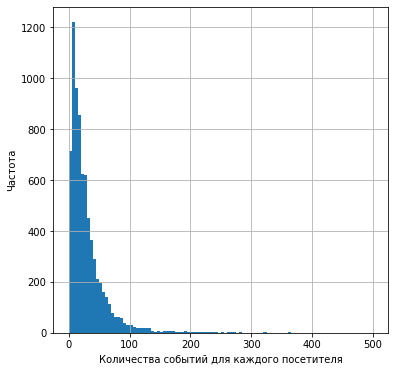

In [18]:
logs_copy.groupby('user_id')['event'].count().hist(bins=100, range=(0,500), figsize=(6,6))
plt.xlabel("Количества событий для каждого посетителя")
plt.ylabel("Частота")
plt.show()

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [19]:
print('Мода количества событий на одного пользователя :',logs_copy.groupby('user_id')['event'].count().mode()[0])

Мода количества событий на одного пользователя : 5


### Временной период

Найдем минимальную и максимальную дату из нашего датасета:

In [20]:
print('Минимальная дата:', logs_copy['date'].min())
print('Максимальная дата:', logs_copy['date'].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


Оценим, сколько у нас набралось данных для анализа:

In [21]:
event_time_grouped = logs_copy.groupby('date')['event_time'].count().reset_index()

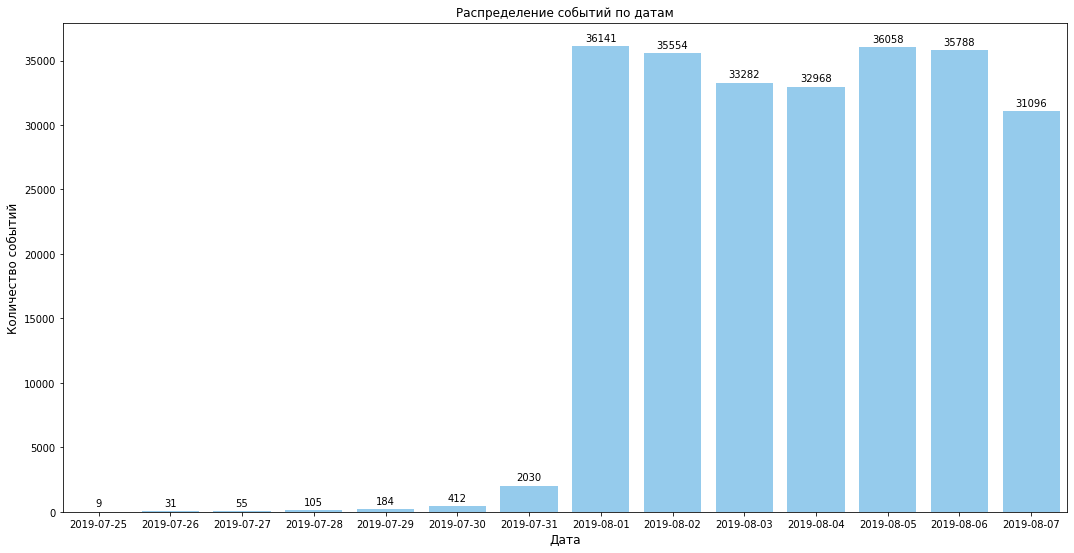

In [22]:
plt.figure(figsize=(18, 9))
ax = sns.barplot(data = event_time_grouped, x = 'date', y='event_time', color='#87CEFA')
plt.title('Распределение событий по датам')
plt.xlabel('Дата', fontsize = 12)
plt.ylabel('Количество событий', fontsize = 12)

#Напишем функцию для отрисовки значений
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        label = "{:.0f}".format(y_value)

        ax.annotate(label,
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points",
            ha='center')

add_value_labels(ax)

По графику видно, что у нас недостаточно сведений по первой неделе, отбросим ее для дальнейшего анализа: 

In [23]:
turndate = pd.to_datetime('2019-08-01', format = '%Y-%m-%d')
logs_copy = logs_copy.loc[logs_copy.loc[:,'date'] >= turndate]

Оценим, сколько событий и пользователей мы потеряли:

In [24]:
events_filtered = len(logs_copy)
users_filtered = logs_copy['user_id'].nunique()

print('Количество событий до фильтрации - {}, после - {}. Разность - {} или {}%'.format(
                                                                        events, events_filtered,
                                                                        events - events_filtered,
                                                                        round(100-events_filtered/events*100, 2)))
print('Количество пользователей до фильтрации - {}, после - {}. Разность - {} или {}%'.format(
                                                                        users, users_filtered,
                                                                        users - users_filtered,
                                                                        round(100-users_filtered/users*100, 2)))

Количество событий до фильтрации - 243713, после - 240887. Разность - 2826 или 1.16%
Количество пользователей до фильтрации - 7551, после - 7534. Разность - 17 или 0.23%


Проверим, что все группы на месте:

In [25]:
logs_copy.groupby('group')['user_id'].nunique()

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

[Обратно к содержанию](#mark_)

# Изучение воронки событий<a name='mark4'></a>

### Какие события есть в логах

Посмотрим, какие события есть в логах и как часто они встречаются:

In [26]:
events_count = logs_copy['event'].value_counts().to_frame()
events_count

,event
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


### Количество пользователей совершавших каждое из этих событий

Найдем количество пользователей, совершивших каждое событие и долю пользователей, которые хоть раз совершали событие:

In [27]:
# Функция для подсчета количества пользователей, выпонивших определенное действие
def get_event_count(event):
    users_count = logs_copy[logs_copy['event'] == event]['user_id'].nunique()
    return users_count

In [28]:
events_count = events_count.reset_index()
events_count['users_count'] = events_count['index'].apply(get_event_count)
events_count = events_count.sort_values(by='users_count', ascending=False)
events_count = events_count.set_index('index')
events_count.index.name = None
events_count['percent'] = events_count['users_count'].apply(lambda x: round(x/7419*100, 2))

In [29]:
events_count['percent_corr'] = events_count['users_count'].apply(lambda x: round(x/users_filtered*100, 2))
events_count

,event,users_count,percent,percent_corr
MainScreenAppear,117328,7419,100.00,98.47
OffersScreenAppear,46333,4593,61.91,60.96
CartScreenAppear,42303,3734,50.33,49.56
PaymentScreenSuccessful,33918,3539,47.70,46.97
Tutorial,1005,840,11.32,11.15


### Последовательность событий

События идут в следующей последовательности:

1) **MainScreenAppear** - пользователь попал на главную страницу;  
2) **OffersScreenAppear** - пользователь перешел на страницу с товаром;  
3) **CartScreenAppear** - пользователь перешел в корзину;  
4) **PaymentScreenSuccessful** - пользователь удачно оплатил товар.  

Событие **Tutorial** (пользователь зашел в руководство по приложению) в данном случае является не обязательным, так как оно не сильно влияет на достижение конечного результата, а является вспомогательным.

Исключим это действие из нашего дальнейшего анализа:

In [30]:
logs_funnel = events_count.drop('Tutorial')

In [31]:
logs_funnel

,event,users_count,percent,percent_corr
MainScreenAppear,117328,7419,100.00,98.47
OffersScreenAppear,46333,4593,61.91,60.96
CartScreenAppear,42303,3734,50.33,49.56
PaymentScreenSuccessful,33918,3539,47.70,46.97


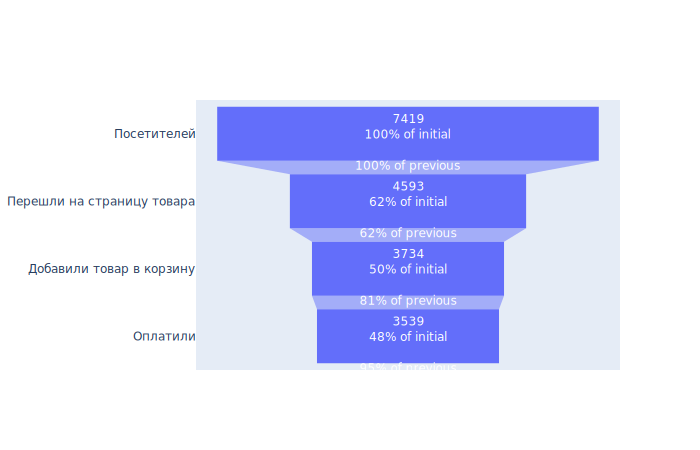

In [32]:
fig = go.Figure(go.Funnel(
                y = ["Посетителей", "Перешли на страницу товара", "Добавили товар в корзину", "Оплатили"],
                x = logs_funnel['users_count'],
                hoverinfo = 'x+y+percent initial+percent previous',
                textposition = "inside",
                textinfo = "value+percent initial+percent previous")
                )
fig.show(renderer='svg')

Больше всего посетителей теряются на втором шаге (переход на страницу товара).  
48% посетителей успешно оформляют у нас покупку.

[Обратно к содержанию](#mark_)

# Изучение результатов эксперимента<a name='mark5'></a>

### Сколько пользователей в каждой экспериментальной группе

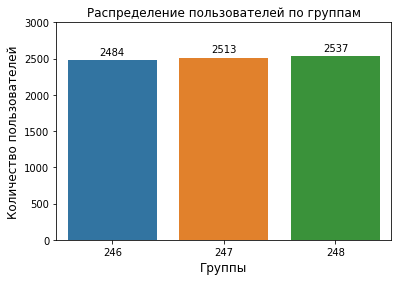

In [33]:
ax = sns.barplot(data=logs_copy.groupby('group')['user_id'].nunique().to_frame().reset_index(), 
                 x='group',
                 y='user_id')
plt.ylim(0, 3000)
plt.title('Распределение пользователей по группам')
plt.xlabel('Группы', fontsize = 12)
plt.ylabel('Количество пользователей', fontsize = 12)

def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        label = "{:.0f}".format(y_value)

        ax.annotate(label,
            (x_value, y_value),         
            xytext=(0, space),          
            textcoords="offset points",
            ha='center')

add_value_labels(ax)

In [34]:
data = logs_copy.groupby('group')['user_id'].nunique().to_frame()
data

,user_id
group,
246,2484
247,2513
248,2537


In [35]:
data.rename(columns={'user_id': 'users_count'}, inplace=True)
data

,users_count
group,
246,2484
247,2513
248,2537


Выведем информацию по событиям по каждой группе:

In [36]:
users_by_events = logs_copy.pivot_table(index = 'group',
                                        columns = 'event',
                                        values = 'user_id',
                                        aggfunc = 'nunique').rename_axis(None)

# Добавим количество пользователей в каждой группе
users_count = logs_copy.groupby('group')['user_id'].nunique().to_frame()
users_count.rename(columns={'user_id': 'users_count'}, inplace=True)
users_by_events = users_by_events.join(users_count)

# Поставим события в логическом порядке
users_by_events = users_by_events[['users_count','MainScreenAppear', 'OffersScreenAppear',
                                   'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']]

#Добавим строку с объединенными данными для двух контрольных групп
new_row = users_by_events.loc[246] + users_by_events.loc[247]
new_row.name = '246+247'
users_by_events = users_by_events.append([new_row])
users_by_events = users_by_events.reindex([246, 247, '246+247', 248])

users_by_events

,users_count,MainScreenAppear,OffersScreenAppear,CartScreenAppear,PaymentScreenSuccessful,Tutorial
246,2484,2450,1542,1266,1200,278
247,2513,2476,1520,1238,1158,283
246+247,4997,4926,3062,2504,2358,561
248,2537,2493,1531,1230,1181,279


У нас есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверем, находят ли статистические критерии разницу между выборками 246 и 247.  
Для этого будем использовать z-тест.  
Сформулируем нулевую гипотезу: между группами 246 и 247 нет статистически значимой разницы. Соответственно альтернативная гипотеза - между группами есть значимая разница.  
Проведем тест на данных по количеству совершивших покупку в каждой группе:

In [37]:
alpha = .05 # критический уровень статистической значимости

users_count = np.array([2484, 2513])
successes = np.array([1200, 1158])

# пропорция успехов в первой группе:
p1 = successes[0]/users_count[0]

# пропорция успехов во второй группе:
p2 = successes[1]/users_count[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (users_count[0] + users_count[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/users_count[0] + 1/users_count[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)  

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными


Напишем функцию, которая поможет нам оптимизировать проведение теста:

In [38]:
def z_test(part0, part1, total0, total1, alpha):  
    alpha = alpha
    p1 = part0 / total0 
    p2 = part1 / total1 
    p_combined = (part0 + part1) / (total0 + total1) 
    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total0 + 1/total1))
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

Проверем результаты АА-теста по всем события:

In [39]:
AA_test_results = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

results = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
           "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

group_1 = 246
group_2 = 247
alpha = .05

for event_number in range(1, 5):
    curr_event = users_by_events.columns[event_number]
    p_value_result = z_test(users_by_events[curr_event][group_1], 
                            users_by_events[curr_event][group_2],
                            users_by_events['users_count'][group_1],
                            users_by_events['users_count'][group_2],
                            alpha = alpha)
    new_row = {'Группа_1': group_1,
               'Группа_2': group_2,
               'Событие': users_by_events.columns[event_number],
               'p_alpha': alpha,
               'p_value': round(p_value_result, 5),
               'Результат': results[p_value_result >= alpha]}
    AA_test_results = AA_test_results.append([new_row])

AA_test_results.index = range(len(AA_test_results))
AA_test_results

C:\Users\glazo\anaconda3\envs\practicum\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,247,MainScreenAppear,0.05,0.75706,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,246,247,OffersScreenAppear,0.05,0.24810,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,246,247,CartScreenAppear,0.05,0.22883,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,246,247,PaymentScreenSuccessful,0.05,0.11457,"Не получилось отвергнуть нулевую гипотезу, нет..."


Группы поделены корректно - статистически значимых различий между 246 и 247 группами не обнаружено.  

Теперь проверим результаты между группой с измененным шрифтом и контрольными группами: 

In [41]:
AB_test_results_2 = pd.DataFrame(columns=['Группа_1', 'Группа_2', 'Событие', 'p_alpha', 'p_value', 'Результат'])

results = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
           "Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными"]

for i in range(3):
    group_1 = users_by_events.index[i]
    group_2 = 248
    alpha = .01
    for event_number in range(1, 5):
        curr_event = users_by_events.columns[event_number]
        p_value_result = z_test(users_by_events[curr_event][group_1], 
                                  users_by_events[curr_event][group_2],
                                  users_by_events['users_count'][group_1],
                                  users_by_events['users_count'][group_2],
                                  alpha = alpha)
        new_row = {'Группа_1': group_1,
                   'Группа_2': group_2,
                   'Событие': users_by_events.columns[event_number],
                   'p_alpha': alpha,
                   'p_value': round(p_value_result, 5),
                   'Результат': results[p_value_result >= 0.05]}
        AB_test_results_2 = AB_test_results_2.append([new_row])

AB_test_results_2.index = range(len(AB_test_results_2))
AB_test_results_2

C:\Users\glazo\anaconda3\envs\practicum\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning:

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



,Группа_1,Группа_2,Событие,p_alpha,p_value,Результат
0,246,248,MainScreenAppear,0.01,0.29497,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,246,248,OffersScreenAppear,0.01,0.20836,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,246,248,CartScreenAppear,0.01,0.07843,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,246,248,PaymentScreenSuccessful,0.01,0.21226,"Не получилось отвергнуть нулевую гипотезу, нет..."
4,247,248,MainScreenAppear,0.01,0.45871,"Не получилось отвергнуть нулевую гипотезу, нет..."
5,247,248,OffersScreenAppear,0.01,0.91978,"Не получилось отвергнуть нулевую гипотезу, нет..."
6,247,248,CartScreenAppear,0.01,0.57862,"Не получилось отвергнуть нулевую гипотезу, нет..."
7,247,248,PaymentScreenSuccessful,0.01,0.73734,"Не получилось отвергнуть нулевую гипотезу, нет..."
8,246+247,248,MainScreenAppear,0.01,0.29425,"Не получилось отвергнуть нулевую гипотезу, нет..."
9,246+247,248,OffersScreenAppear,0.01,0.43426,"Не получилось отвергнуть нулевую гипотезу, нет..."


Статистически значимых различий между 248-й и контрольными гуппами не обнаружено.  

Мы проводим множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применим методы Холма и Шидака:

In [42]:
result_options = ["Отвергаем нулевую гипотезу - между долями есть статзначимая разница",
                  "Не получилось отвергнуть нулевую гипотезу, нет достаточных оснований считать доли разными"]

pvalues_corr_list_2 = []  # откорректированные p-value
final_results_2 = []  # итоговые результаты (отклоняем или нет)

alpha = .05
pvalues_list_2 = AB_test_results_2['p_value'].tolist()
results_2, p_value_corr_2, _, _ = multipletests(pvalues_list_2, alpha = alpha, method='holm-sidak')
pvalues_corr_list_2.extend([round(x, 5) for x in p_value_corr_2])
final_results_2.extend([result_options[0] if x else result_options[1] for x in results_2])

AB_test_results_2 = AB_test_results_2.drop('Результат', axis=1)
AB_test_results_2['p_value_corr'] = pvalues_corr_list_2
AB_test_results_2['Итоговый результат'] = final_results_2
AB_test_results_2

,Группа_1,Группа_2,Событие,p_alpha,p_value,p_value_corr,Итоговый результат
0,246,248,MainScreenAppear,0.01,0.29497,0.93845,"Не получилось отвергнуть нулевую гипотезу, нет..."
1,246,248,OffersScreenAppear,0.01,0.20836,0.90333,"Не получилось отвергнуть нулевую гипотезу, нет..."
2,246,248,CartScreenAppear,0.01,0.07843,0.62473,"Не получилось отвергнуть нулевую гипотезу, нет..."
3,246,248,PaymentScreenSuccessful,0.01,0.21226,0.90333,"Не получилось отвергнуть нулевую гипотезу, нет..."
4,247,248,MainScreenAppear,0.01,0.45871,0.96721,"Не получилось отвергнуть нулевую гипотезу, нет..."
5,247,248,OffersScreenAppear,0.01,0.91978,0.96847,"Не получилось отвергнуть нулевую гипотезу, нет..."
6,247,248,CartScreenAppear,0.01,0.57862,0.96847,"Не получилось отвергнуть нулевую гипотезу, нет..."
7,247,248,PaymentScreenSuccessful,0.01,0.73734,0.96847,"Не получилось отвергнуть нулевую гипотезу, нет..."
8,246+247,248,MainScreenAppear,0.01,0.29425,0.93845,"Не получилось отвергнуть нулевую гипотезу, нет..."
9,246+247,248,OffersScreenAppear,0.01,0.43426,0.96721,"Не получилось отвергнуть нулевую гипотезу, нет..."


### Выводы
Статистически значимых различий между двумя контрольными группами со старыми шрифтами и экспериментальной (с новыми шрифтами) не удалось обнаружить. Значит гипотеза о том, что изменение шрифта на главной странице как-то повлияет на конверсию, не подтвердилась.  
Возможно стоит еще раз провести тест спустя неделю, когда у нас станет больше исходных данных. Однако, учитывая довольно высокие значения p-value на это не стоит надеяться.

[Обратно к содержанию](#mark_)